## SPARC-4 mini-pipeline tools
***
# <font color='darkblue'>Polarimetry</font> 

This notebook shows an example for obtaining a polarimetric analysis of a set of observations using the SPARC4 instrument in polarimetric mode with both half-wave and quarter-wave rotating plates. It takes as input a series of science imaging products `*_proc.fits` obtained with the SPARC4 pipeline.

* Eder Martioli, LNA 20 Jun 2023

<div class="alert alert-block alert-warning">
<b>WARNING:</b> it requires running <b>sp4_sci_image_reduction.ipynb</b> in advance, for the same channel and modes, to generate *_proc.fits reduced files
</div>

In [1]:
import os,sys
sys.path.append(os.path.dirname(os.getcwd()))
import sparc4_product_plots as s4plt
import sparc4_pipeline_lib as s4pipelib
import sparc4_utils as s4utils
import sparc4_db as s4db

/Users/eder/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## User inputs

In [2]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "HD111579"

# set night directory name
NIGHTDIR = '20230503'
# set raw data root directory
DATADIR =  "/Volumes/Samsung_T5/Data/SPARC4/minidata/"
# set reduced data root directory
REDUCEDDIR = "/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced/"

# set SPARC4 channel
CHANNEL = 4  # 1, 2, 3 or 4

# whether or not to force reduction even if product already exists
FORCE = False

# get SPARC4 pipeline parameters
p = s4pipelib.init_s4_p(datadir=DATADIR,
                        reducedir=REDUCEDDIR,
                        nightdir=NIGHTDIR,
                        channels="{}".format(CHANNEL),
                        print_report=False)

# create database of raw data for reduction
db = s4db.create_db_from_observations(p['filelists'][CHANNEL-1], 
                                      p['DB_KEYS'], 
                                      include_img_statistics=p["INCLUDE_IMG_STATISTICS"], 
                                      include_only_fullframe=p["FULL_FRAMES_ONLY"], 
                                      output=p['s4db_files'][CHANNEL-1])

# detect all detector modes
detector_modes = s4db.get_detector_modes_observed(db, 
                                                  science_only=True,
                                                  detector_keys=p["DETECTOR_MODE_KEYWORDS"])
# get first valid key
mode_key = next(iter(detector_modes))

# set PHOTOMETRIC mode
inst_mode = p['INSTMODE_POLARIMETRY_KEYVALUE']

# we need the reduce directory 
reduce_ch_dir = p['reduce_directories'][CHANNEL-1]

# 1. Calculate `HALF-WAVE` POLARIMETRY

Adding seq 1 of 16 files
Number of sources in catalog: 36
Number of apertures: 49  varying from 2.0 to 50.0 in steps of 1.0 pix
Calculating halfwave polarimetry for aperture 1 of 49
Calculating halfwave polarimetry for aperture 2 of 49
Calculating halfwave polarimetry for aperture 3 of 49
Calculating halfwave polarimetry for aperture 4 of 49
Calculating halfwave polarimetry for aperture 5 of 49
Calculating halfwave polarimetry for aperture 6 of 49
Calculating halfwave polarimetry for aperture 7 of 49
Calculating halfwave polarimetry for aperture 8 of 49
Calculating halfwave polarimetry for aperture 9 of 49
Calculating halfwave polarimetry for aperture 10 of 49
Calculating halfwave polarimetry for aperture 11 of 49
Calculating halfwave polarimetry for aperture 12 of 49
Calculating halfwave polarimetry for aperture 13 of 49
Calculating halfwave polarimetry for aperture 14 of 49
Calculating halfwave polarimetry for aperture 15 of 49
Calculating halfwave polarimetry for aperture 16 of 49
C

/Volumes/Samsung_T5/sparc4-pipeline/sparc4_pipeline_lib.py:2298: RuntimeWarning: divide by zero encountered in double_scalars
  chi2 = np.nansum(((norm.zi.nominal - observed_model)/norm.zi.std_dev)**2) / (number_of_observations - number_of_free_params)


Calculating halfwave polarimetry for aperture 30 of 49
Calculating halfwave polarimetry for aperture 31 of 49
Calculating halfwave polarimetry for aperture 32 of 49
Calculating halfwave polarimetry for aperture 33 of 49
Calculating halfwave polarimetry for aperture 34 of 49
Calculating halfwave polarimetry for aperture 35 of 49
Calculating halfwave polarimetry for aperture 36 of 49
Calculating halfwave polarimetry for aperture 37 of 49
Calculating halfwave polarimetry for aperture 38 of 49
Calculating halfwave polarimetry for aperture 39 of 49
Calculating halfwave polarimetry for aperture 40 of 49
Calculating halfwave polarimetry for aperture 41 of 49
Calculating halfwave polarimetry for aperture 42 of 49
Calculating halfwave polarimetry for aperture 43 of 49
Calculating halfwave polarimetry for aperture 44 of 49
Calculating halfwave polarimetry for aperture 45 of 49
Calculating halfwave polarimetry for aperture 46 of 49
Calculating halfwave polarimetry for aperture 47 of 49
Calculatin

Calculating halfwave polarimetry for aperture 49 of 49
Saving output halfwave polarimetry product: /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503//20230503_s4c4_002119_hd111_l2_polar.fits
Source index: i=0 
Source RA=280.1658104676077 Dec=-6.743094437918167 mag=-16.6809+-0.0005
Best aperture radius: 8.0 pixels
Polarization in Q: 0.0258+-0.0008
Polarization in U: -0.0349+-0.0008
Polarization in V: nan+-nan
Total linear polarization p: 0.0434+-0.0008
Angle of polarization theta: 153.2+-0.5
Free constant k: 0.9697365707237571+-nan
Zero of polarization: 0.0+-0.0
RMS of zi residuals: 0.00202
Reduced chi-square (n=16.0, DOF=11.0): 1.56


/Users/eder/anaconda3/lib/python3.7/site-packages/astropop/math/physical.py:100: RuntimeWarning: divide by zero encountered in log10
  return -np.int_(np.floor(np.log10(np.abs(std)))) + sig - 1


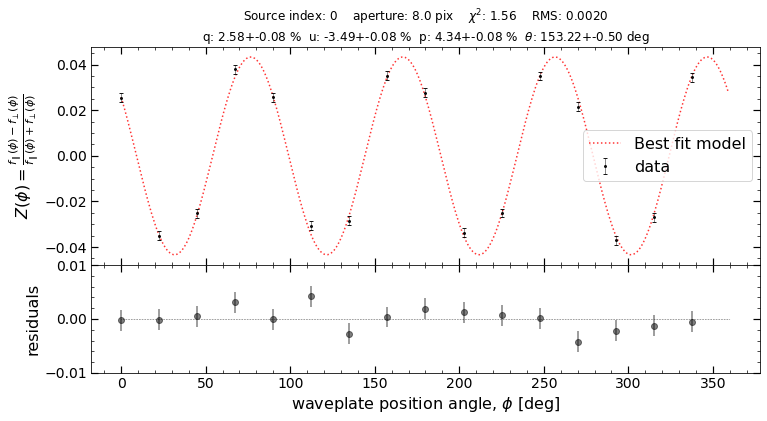

In [5]:
# First set the polar mode and waveplate to "halfwave"
polar_mode = p['POLARIMETRY_L2_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode, polar_mode)

# get list of objects observed in polarimetric mode
objs = s4db.get_targets_observed(db, 
                                 inst_mode=inst_mode, 
                                 polar_mode=polar_mode, 
                                 detector_mode=detector_modes[mode_key])

# select object's data 
if OBJECTID != "all" :
    objs = objs[objs['OBJECT'] == OBJECTID]

    
# loop over each object to run the reduction
for k in range(len(objs)) :
    obj = objs[k][0]
    
    # set suffix for output time series filename
    ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                     p['CHANNELS'][CHANNEL-1] ,
                                     obj.replace(" ",""), 
                                     polsuffix)    
    
    # get list of science data matching object, detector mode, inst. mode, and polar mode
    raw_sci_list = s4db.get_file_list(db,
                                      object_id=obj, 
                                      inst_mode=inst_mode, 
                                      polar_mode=polar_mode, 
                                      obstype=p['OBJECT_OBSTYPE_KEYVALUE'], 
                                      calwheel_mode=None, 
                                      detector_mode=detector_modes[mode_key])
    # input reduced files list
    sci_list = ["{}/{}".format(reduce_ch_dir, os.path.basename(f).replace(".fits","_proc.fits")) for f in raw_sci_list]
    
    # group input list into polarimetric sequences
    pol_sequences = s4utils.select_polar_sequences(sci_list, sortlist=True, verbose=True)
    
    for i in range(len(pol_sequences)) :    
        
        if len(pol_sequences[i]) == 0 :
            continue
            
        polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i],
                                                     wave_plate = 'halfwave',
                                                     base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     compute_k = True,
                                                     fit_zero = False,
                                                     zero = 0)

        pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                        source_index=0,
                                                        min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                        max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                        plot=True,
                                                        verbose=True)

# 2. Calculate `QUARTER-WAVE` POLARIMETRY

Adding seq 1 of 16 files


2023-06-20 22:05:08,457 astropop - INFO - Normalization disabled.  [__init__]


Number of sources in catalog: 32
Number of apertures: 49  varying from 2.0 to 50.0 in steps of 1.0 pix
Calculating quarterwave polarimetry for aperture 1 of 49
Calculating quarterwave polarimetry for aperture 2 of 49
Calculating quarterwave polarimetry for aperture 3 of 49
Calculating quarterwave polarimetry for aperture 4 of 49
Calculating quarterwave polarimetry for aperture 5 of 49
Calculating quarterwave polarimetry for aperture 6 of 49
Calculating quarterwave polarimetry for aperture 7 of 49
Calculating quarterwave polarimetry for aperture 8 of 49
Calculating quarterwave polarimetry for aperture 9 of 49
Calculating quarterwave polarimetry for aperture 10 of 49
Calculating quarterwave polarimetry for aperture 11 of 49
Calculating quarterwave polarimetry for aperture 12 of 49
Calculating quarterwave polarimetry for aperture 13 of 49
Calculating quarterwave polarimetry for aperture 14 of 49
Calculating quarterwave polarimetry for aperture 15 of 49
Calculating quarterwave polarimetry 

/Volumes/Samsung_T5/sparc4-pipeline/sparc4_pipeline_lib.py:2298: RuntimeWarning: divide by zero encountered in double_scalars
  chi2 = np.nansum(((norm.zi.nominal - observed_model)/norm.zi.std_dev)**2) / (number_of_observations - number_of_free_params)


Calculating quarterwave polarimetry for aperture 32 of 49
Calculating quarterwave polarimetry for aperture 33 of 49
Calculating quarterwave polarimetry for aperture 34 of 49
Calculating quarterwave polarimetry for aperture 35 of 49


/Users/eder/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Calculating quarterwave polarimetry for aperture 36 of 49
Calculating quarterwave polarimetry for aperture 37 of 49
Calculating quarterwave polarimetry for aperture 38 of 49
Calculating quarterwave polarimetry for aperture 39 of 49
Calculating quarterwave polarimetry for aperture 40 of 49
Calculating quarterwave polarimetry for aperture 41 of 49
Calculating quarterwave polarimetry for aperture 42 of 49
Calculating quarterwave polarimetry for aperture 43 of 49
Calculating quarterwave polarimetry for aperture 44 of 49
Calculating quarterwave polarimetry for aperture 45 of 49
Calculating quarterwave polarimetry for aperture 46 of 49
Calculating quarterwave polarimetry for aperture 47 of 49
Calculating quarterwave polarimetry for aperture 48 of 49
Calculating quarterwave polarimetry for aperture 49 of 49
Saving output quarterwave polarimetry product: /Volumes/Samsung_T5/Data/SPARC4/minidata/reduced//sparc4acs4//20230503//20230503_s4c4_002135_hd1l4_l4_polar.fits
Source index: i=0 
Source RA

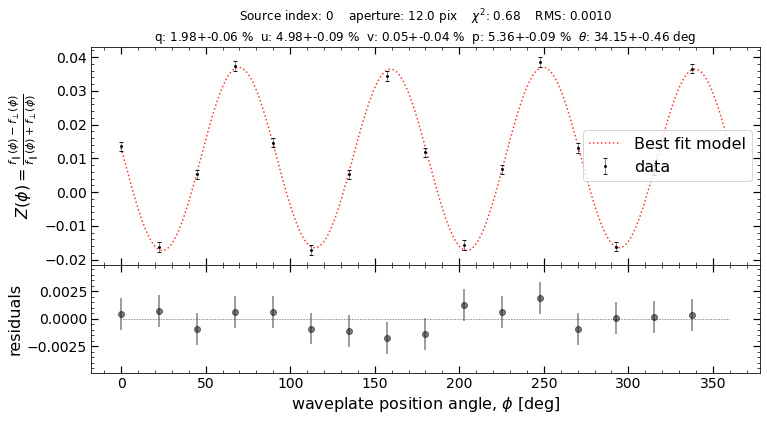

In [6]:
# First set the polar mode and waveplate to "halfwave"
polar_mode = p['POLARIMETRY_L4_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode, polar_mode)

# get list of objects observed in polarimetric mode
objs = s4db.get_targets_observed(db, 
                                 inst_mode=inst_mode, 
                                 polar_mode=polar_mode, 
                                 detector_mode=detector_modes[mode_key])

# select object's data 
if OBJECTID != "all" :
    objs = objs[objs['OBJECT'] == OBJECTID]

    
# loop over each object to run the reduction
for k in range(len(objs)) :
    obj = objs[k][0]
    
    # set suffix for output time series filename
    ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                     p['CHANNELS'][CHANNEL-1] ,
                                     obj.replace(" ",""), 
                                     polsuffix)    
    
    # get list of science data matching object, detector mode, inst. mode, and polar mode
    raw_sci_list = s4db.get_file_list(db,
                                      object_id=obj, 
                                      inst_mode=inst_mode, 
                                      polar_mode=polar_mode, 
                                      obstype=p['OBJECT_OBSTYPE_KEYVALUE'], 
                                      calwheel_mode=None, 
                                      detector_mode=detector_modes[mode_key])
    # input reduced files list
    sci_list = ["{}/{}".format(reduce_ch_dir, os.path.basename(f).replace(".fits","_proc.fits")) for f in raw_sci_list]
    
    # group input list into polarimetric sequences
    pol_sequences = s4utils.select_polar_sequences(sci_list, sortlist=True, verbose=True)
    
    for i in range(len(pol_sequences)) :    
        
        if len(pol_sequences[i]) == 0 :
            continue
            
        polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i],
                                                     wave_plate = 'quarterwave',
                                                     base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     compute_k = False,
                                                     fit_zero = True,
                                                     zero = None)

        pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                        source_index=0,
                                                        min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                        max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                        plot=True,
                                                        verbose=True)